This notebooks is dedicated to the implementation of the most frequently used models in RecSys: **Matrix Factorization** using **Alternate Least Squares** optimization method.


#### Why use MF in recommendations?
Recommendations are very wide-spread in retail, where usually the number of products surpasses the number of users by a very big margin. That means that item-user matrix is highly sparse and, due to that matter, very inefficient for storing information about previous user purchases. Besides, it is really hard to compare vectors of high sparsity and, therefore, it is also very hard to make recommendations based on KNN.

#### What is the optimization problem in MF?
In MF we optimize the following function: $L=SSE/MSE/RMSE(R,U^TI)+\lambda_U ||U||_2+\lambda_I ||I||_2$, where $R$ is an initial user-item matrix, $U$ - user approximation matrix of some arbitrary dimension $k$, $I$ - item matrix of the same dimension $k$, $\lambda_{U/I}$ - importances of regularization terms, $||U/I||_2$ - L2 norms for matrices we're approximating.

#### What is ALS?
Alternate Least Squares is a method, which follows the following algorithm:
* We start by differentiating with respect to $U$: $\frac{dL}{dx_u}$ and solve $U$ and get new $U'$ while treating $I$ as constant, preliminary initializing matrices $U$ and $I$ with random values;
* Then differentiate with respect to $I$ and get a newly optimized $I'$ while treating $U'$ as constant;
* Repeat until convergence

#### Why ALS instead of SGD?
ALS tends to be more accurate in approximating sparse matrices (which is most of the time in MF for RecSys), but for **non-sparse MF** case SGD is indeed able to optimize the function better (https://cs229.stanford.edu/proj2014/Christopher%20Aberger,%20Recommender.pdf). The same reference paper also provides information on the weighted ALS algorithm, which could also be given a shot, however it uses more memory than ALS.

#### Building a simple Explicit MF framework


In [1]:
import torch
from torch import nn

class ExplicitMF(nn.Module):

    def __init__(self, n, m, k, lambdaU, lambdaI, *args, **kwargs) -> None:
        """
        Explicit Matrix Factorization model. The name "explicit"
        entails that we are finding definite representations of matrices
        of items and users within R^k space. Implicit algorithms
        entail assumptions.

        - n: int
            - Number of users
        - m: int
            - Number of items
        - k: int
            - Number of latent factors
        - lambdaU: float
            - Regularization term for the U matrix
        - lambdaI: float
            - Regulariztion term for the I matrix
        """
        super().__init__(*args, **kwargs)
        self.U = nn.Embedding(n, k)
        self.I = nn.Embedding(m, k)
        
        self.U_bias = nn.Embedding(n, 1)
        self.I_bias = nn.Embedding(m, 1)
        self.lu = lambdaU
        self.li = lambdaI

    def forward(self, uIndices, iIndices):
        """
        In the forward method we expect a batch of indices from
        the original R matrix. We're return BMM on these indices
        """

        return torch.einsum('ij,jk -> ik', self.U(uIndices), 
                            self.I(iIndices).permute(1,0)) + \
                            self.U_bias(uIndices) + self.I_bias(iIndices) + \
                            self.lu * self.U(uIndices).norm(dim=1, p=2) + \
                            self.li * self.I(iIndices).norm(dim=1, p=2)

#### Crunching some data
For the sake of simplicity we're going to use a classic Movielens dataset available on http://files.grouplens.org/datasets/movielens/ml-100k.zip . Datasets like IMDB ratings available on Kaggle have millions of rows, hence they take a toll on the limited recourses I'm in possession of.

In [2]:
import polars as pl

ds_path = './data/recsys/movielens/u.data'
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pl.read_csv(ds_path, separator='\t', has_header=False, new_columns=names)
df.head(1), df.shape

(shape: (1, 4)
 ┌─────────┬─────────┬────────┬───────────┐
 │ user_id ┆ item_id ┆ rating ┆ timestamp │
 │ ---     ┆ ---     ┆ ---    ┆ ---       │
 │ i64     ┆ i64     ┆ i64    ┆ i64       │
 ╞═════════╪═════════╪════════╪═══════════╡
 │ 196     ┆ 242     ┆ 3      ┆ 881250949 │
 └─────────┴─────────┴────────┴───────────┘,
 (100000, 4))

Mapping out each user and item with their correponding index in the $R$ matrix. This way we can later fill out the $R$ matrix with rating values.

In [3]:
# creating a dict with keys corresponding
# to movie/user ids and values corresponding to
# the their index in the R matrix

def build_hashmap(df_, col):
    return {id_[0]: index for index, id_ in enumerate(
        df_.select(col).unique(maintain_order=True).select(col).iter_rows())}

mov2idx = build_hashmap(df, 'item_id')
usr2idx = build_hashmap(df, 'user_id')
list(mov2idx.items())[:3], list(usr2idx.items())[:3] 

([(242, 0), (302, 1), (377, 2)], [(196, 0), (186, 1), (22, 2)])

In [4]:
# mapping out movies and users by their corresponding
# indices in the R matrix

df = df.with_columns(
    mov2idx=pl.col("item_id").replace(mov2idx, default=None),
    usr2idx=pl.col('user_id').replace(usr2idx, default=None)
)
df.sample(2)

user_id,item_id,rating,timestamp,mov2idx,usr2idx
i64,i64,i64,i64,i64,i64
527,655,3,879456464,431,528
95,294,2,884266083,95,24


Unifying `mov2idx` and `usr2idx` under a single torch.Dataset

In [5]:
from torch.utils import data

class UI_ds(data.Dataset):

    def __init__(self, Uindices, Iindices) -> None:
        super().__init__()
        self.U = Uindices
        self.I = Iindices 

    def __len__(self):
        return len(self.U)
    
    def __getitem__(self, idx):
        return (
            self.U[idx],
            self.I[idx]
        )

In [6]:
ds = UI_ds(df.get_column('usr2idx').to_list(), 
           df.get_column('mov2idx').to_list())
ds[:2]

([0, 1], [0, 1])

Creating and filling up a sparse $R$ matrix

In [27]:
n, m = df.select('usr2idx').max().item()+1,\
    df.select('mov2idx').max().item()+1
R = torch.zeros((n, m))

for pairIndex, rating in enumerate(df.get_column('rating').to_list()):
    Ui, Ii = ds[pairIndex][0], ds[pairIndex][1]
    R[Ui, Ii] = rating 
R, f'% of sparsity: {(R.type(torch.int64) == 0).sum() / (R.shape[0]*R.shape[1])}'

(tensor([[3., 0., 0.,  ..., 0., 0., 0.],
         [0., 3., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 4., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 '% of sparsity: 0.9369533061981201')

Introducing batching with torch.DataLoader's

In [8]:
train_dl = data.DataLoader(ds,batch_size=32,shuffle=True)
len(train_dl)

3125

#### Setting up training
Initializing ExplicitMF model, custom RMSE loss instead of regular MSE/SSE and Adam optimizer (since experimentally SGD proved worse results)

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ExplicitMF(n=n,m=m,k=16,
                   lambdaU=0,
                   lambdaI=0).to(device)
model

ExplicitMF(
  (U): Embedding(943, 16)
  (I): Embedding(1682, 16)
  (U_bias): Embedding(943, 1)
  (I_bias): Embedding(1682, 1)
)

In [23]:
# custom RMSE loss 

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yHat, y):
        return torch.sqrt(self.mse(yHat,y)+self.eps)

In [24]:
trainParams = {
    'lr': .001,
    'max_epochs': 10,
    'sgdMomentum': .005,
    'verbose': 1
}

criterion = RMSELoss().to(device)
optim = torch.optim.Adam(model.parameters(), lr=trainParams['lr'])

#### Running training with ALS (first) and without it (second)

In [25]:
from tqdm import tqdm
from sklearn.metrics import r2_score
import numpy as np

r2Scores = []
avRMSE = []

for epoch in range(trainParams['max_epochs']):
    RMSElosses = []
    predicted = []
    RCopy = []

    for (userIndices, itemIndices) in tqdm(train_dl):
        
        userIndices, itemIndices = torch.Tensor(userIndices).to(device).flatten(), \
            torch.Tensor(itemIndices).to(device).flatten()
        R_cur = R.to(device)[userIndices, :][:, itemIndices]

        # ALS optimization
        # dL/dU
        optim.zero_grad()
        model.U.requires_grad_(True) # enable U matrix
        yPred = model(userIndices, itemIndices)
        model.I.requires_grad_(False) # set I matrix to const
        loss = criterion(yPred,R_cur.to(device))
        RMSElosses.append(loss.item())
        loss.backward()
        optim.step()

        # dL/dI
        model.I.requires_grad_(True) # enable I matrix
        yPred = model(userIndices, itemIndices)
        model.U.requires_grad_(False) # set U matrix to const
        loss = criterion(yPred,R_cur.to(device))
        RMSElosses.append(loss.item())
        loss.backward()
        optim.step()
        
        predicted.append(yPred.cpu().detach().numpy())
        RCopy.append(R_cur.cpu().detach().numpy())

    avRMSE.append(np.array(RMSElosses).mean())
    r2Scores.append(r2_score(np.vstack(RCopy),np.vstack(predicted)))
    
    if epoch % trainParams['verbose'] == 0:
        print(f'Epoch {epoch+1} :: av. RMSE:',avRMSE[-1],':: R^2:',r2Scores[-1]) 

del RCopy
del predicted
del RMSElosses

100%|██████████| 3125/3125 [00:15<00:00, 205.89it/s]


Epoch 1 :: av. RMSE: 3.216707728061676 :: R^2: -2.29369226888908


100%|██████████| 3125/3125 [00:14<00:00, 220.40it/s]


Epoch 2 :: av. RMSE: 1.8322175698280334 :: R^2: -0.023717218230657665


100%|██████████| 3125/3125 [00:14<00:00, 218.65it/s]


Epoch 3 :: av. RMSE: 1.4992986035537719 :: R^2: 0.3204968714620276


100%|██████████| 3125/3125 [00:15<00:00, 203.91it/s]


Epoch 4 :: av. RMSE: 1.378296848373413 :: R^2: 0.4257019239793146


100%|██████████| 3125/3125 [00:16<00:00, 188.34it/s]


Epoch 5 :: av. RMSE: 1.3180868272209167 :: R^2: 0.4747628006347146


100%|██████████| 3125/3125 [00:16<00:00, 186.65it/s]


Epoch 6 :: av. RMSE: 1.2899841757583619 :: R^2: 0.4974100925590826


100%|██████████| 3125/3125 [00:16<00:00, 189.30it/s]


Epoch 7 :: av. RMSE: 1.2729399657249452 :: R^2: 0.5106855429499835


100%|██████████| 3125/3125 [00:17<00:00, 183.77it/s]


Epoch 8 :: av. RMSE: 1.2595061617851258 :: R^2: 0.5206408329066652


100%|██████████| 3125/3125 [00:16<00:00, 187.40it/s]


Epoch 9 :: av. RMSE: 1.251296572227478 :: R^2: 0.5271481006306975


100%|██████████| 3125/3125 [00:16<00:00, 186.40it/s]

Epoch 10 :: av. RMSE: 1.2430461672592164 :: R^2: 0.5328938446412106


Learning curve with ALS:

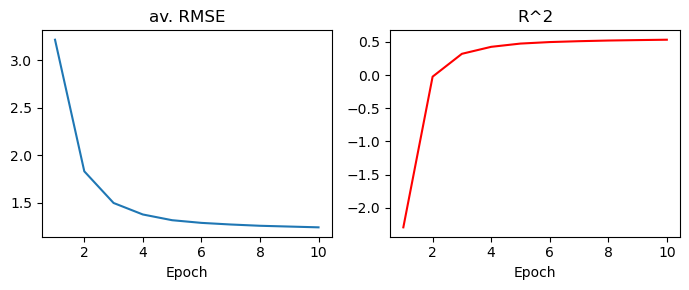

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(7,3))
axs[0].plot(list(range(1,11)),avRMSE,label='av. RMSE')
axs[1].plot(list(range(1,11)),r2Scores,c='red')
axs[0].set(
    xlabel='Epoch',
    title='av. RMSE')
axs[1].set(
    xlabel='Epoch',
    title='R^2',)
fig.tight_layout()

In [148]:
from tqdm import tqdm
from sklearn.metrics import r2_score
import numpy as np

r2Scores = []
avRMSE = []

for epoch in range(trainParams['max_epochs']):
    RMSElosses = []
    predicted = []
    RCopy = []
    for (userIndices, itemIndices) in tqdm(train_dl):
        optim.zero_grad()
        userIndices, itemIndices = torch.Tensor(userIndices).to(device).flatten(), \
            torch.Tensor(itemIndices).to(device).flatten()
        R_cur = R[userIndices, :][:, itemIndices]
        yPred = model(userIndices, itemIndices)

        # logging predicted and true values for R^2 calculation
        predicted.append(yPred.cpu().detach().numpy())
        RCopy.append(R_cur.cpu().detach().numpy())

        loss = criterion(yPred,R_cur.to(device))
        RMSElosses.append(loss.item())
        loss.backward()
        optim.step()

    avRMSE.append(np.array(RMSElosses).mean())
    r2Scores.append(r2_score(np.vstack(RCopy),np.vstack(predicted)))
    
    if epoch % trainParams['verbose'] == 0:
        print(f'Epoch {epoch+1} :: av. RMSE:',avRMSE[-1],':: R^2:',r2Scores[-1]) 

del RCopy
del predicted
del RMSElosses

100%|██████████| 3125/3125 [00:06<00:00, 462.78it/s]


Epoch 1 :: av. RMSE: 3.628088639831543 :: R^2: -3.0817349718521427


100%|██████████| 3125/3125 [00:06<00:00, 499.02it/s]


Epoch 2 :: av. RMSE: 2.3091108922576904 :: R^2: -0.6297204370791647


100%|██████████| 3125/3125 [00:06<00:00, 493.63it/s]


Epoch 3 :: av. RMSE: 1.753626803741455 :: R^2: 0.06821553758265844


100%|██████████| 3125/3125 [00:06<00:00, 494.73it/s]


Epoch 4 :: av. RMSE: 1.5313699913406371 :: R^2: 0.2902840312745272


100%|██████████| 3125/3125 [00:06<00:00, 509.01it/s]


Epoch 5 :: av. RMSE: 1.4093138665008544 :: R^2: 0.39922415727073823


100%|██████████| 3125/3125 [00:06<00:00, 497.15it/s]


Epoch 6 :: av. RMSE: 1.3416297828674317 :: R^2: 0.4557987565586378


100%|██████████| 3125/3125 [00:06<00:00, 498.65it/s]


Epoch 7 :: av. RMSE: 1.3020609611511231 :: R^2: 0.4873108353102088


100%|██████████| 3125/3125 [00:06<00:00, 505.02it/s]


Epoch 8 :: av. RMSE: 1.274590757484436 :: R^2: 0.5083352146908868


100%|██████████| 3125/3125 [00:06<00:00, 493.45it/s]


Epoch 9 :: av. RMSE: 1.2552505477523803 :: R^2: 0.523581549234004


100%|██████████| 3125/3125 [00:06<00:00, 497.24it/s]


Epoch 10 :: av. RMSE: 1.2409143450737 :: R^2: 0.5337493381264595


Full gradient Adam without ALS:

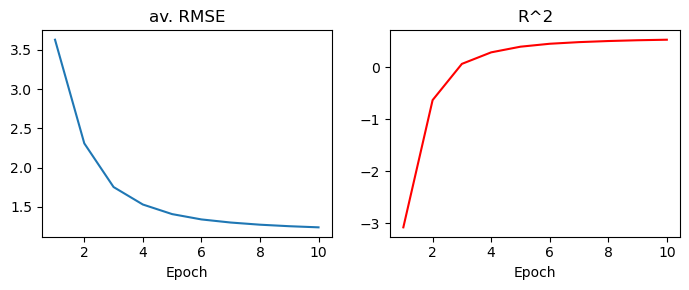

In [159]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(7,3))
axs[0].plot(list(range(1,11)),avRMSE,label='av. RMSE')
axs[1].plot(list(range(1,11)),r2Scores,c='red')
axs[0].set(
    xlabel='Epoch',
    title='av. RMSE')
axs[1].set(
    xlabel='Epoch',
    title='R^2',)
fig.tight_layout()

Results look quite promising and we can ideed see that the learning curve using ALS is a bit steeper in comparison to the case without ALS, which proves that ALS optimization might be more applicable to matrices of sparsity of $\geq 93\%$ (the percentage is calculated in the cell with building the $R$ matrix)

#### Testing trained explicit MF on some data
First we pull the data on ids of movies and their correponding titles

In [28]:
ds_path = './data/recsys/movielens/u.item'
mov_df = pl.read_csv(ds_path, separator='|', 
                 has_header=False, encoding='Windows-1251')
mov_df = mov_df.rename({'column_1': 'id', 'column_2': 'title'})
mov_df = mov_df.select(['id','title'])
mov_df.head(2)

id,title
i64,str
1,"""Toy Story (1995)"""
2,"""GoldenEye (1995)"""


Using approximated $U$ and $I$ matrices we can now do things like recommending movies to a particular user (ranking them based on assumed rating he might give them):

In [38]:
def createUsrEmbed(userId):
    """ 
    Provide an embedding for a given user upon all
    other movies
    """

    model.eval()
    userIndex, itemsIndices = torch.Tensor([usr2idx[userId]]).type(torch.int64).to(device), \
        torch.arange(0,len(mov2idx)).to(device)
    with torch.no_grad():
        embedding = model.U(userIndex) @ model.I(itemsIndices).permute(1,0)
    model.train()
    return embedding.cpu().detach()

In [53]:
# using a user embedding we can rank movies based on predicted
# ratings a user might give it

embeddings = createUsrEmbed(df.get_column('user_id').sample(1).item()).squeeze(0)
mov_df.filter(pl.col('id').is_in(
    embeddings.argsort(descending=True)[:5].tolist()
))

id,title
i64,str
52,"""Madness of King George, The (1…"
96,"""Terminator 2: Judgment Day (19…"
182,"""GoodFellas (1990)"""
217,"""Bram Stoker's Dracula (1992)"""
357,"""One Flew Over the Cuckoo's Nes…"


Or find closest neighbours based on cosine similarity between embeddings in $I$ and allow finding search-based recommendations: 

In [62]:
from torch.nn.functional import cosine_similarity as cossim

idx2mov = {v: k for k, v in mov2idx.items()}

def getTopK(k: int, movId: int):
    """
    Get top k movies for particular movie with id=movId
    """

    movIndex, movIndices = torch.Tensor([mov2idx[movId]]).type(torch.int64).to(device), \
        torch.arange(0,len(mov2idx)).to(device)

    model.eval()
    with torch.no_grad():
        topKIndices = cossim(model.I(movIndex), 
                             model.I(movIndices))\
                                .argsort(descending=True)[:k]
    model.train()

    return [idx2mov[idx.item()] for idx in topKIndices]

We can then try getting top 10 movies for the "Terminator 2". As we can see in just $16$ latent factors we've managed to capture a pretty good amount of information, as all of recommendations match the movie's genre with some even casting Schwarzenegger as well:

In [65]:
terminatorID = 96
mov_df.filter(pl.col('id').is_in(
    getTopK(10,terminatorID)
))

id,title
i64,str
2,"""GoldenEye (1995)"""
82,"""Jurassic Park (1993)"""
96,"""Terminator 2: Judgment Day (19…"
144,"""Die Hard (1988)"""
176,"""Aliens (1986)"""
195,"""Terminator, The (1984)"""
233,"""Under Siege (1992)"""
385,"""True Lies (1994)"""
568,"""Speed (1994)"""
